In [51]:
########################################
# STEP 0: import libraries #ASK ABOUT ACCURACY VS RECAL
########################################
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer 
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
import sklearn.tree
import sklearn.ensemble
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
import nltk
import pandas as pd
import sklearn.datasets
import sklearn.decomposition
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.random_projection
import sklearn.tree
import sklearn.svm
nltk.download('vader_lexicon') # Should print 3.9.1 or another recent version




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\agrey25\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [52]:
###reading in initial###
df = pd.read_csv(("~/Downloads/modeling_data.csv"))
df.head(1)

,X,fullText,day,Harris,Trump,July,August,September,October,November,likes,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment
0,6232,i think what people aren’t taking about enough...,14,0,1,0,1,0,0,0,0.000025,0.00001,0.000023,0.000019,0.020858,1,trump,indirect,negative


In [53]:
########################################
# SUB-STEP: Prepare the dataset
########################################
analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    return analyzer.polarity_scores(text)['compound']

df['vader_score'] = df['fullText'].apply(get_vader_score)


def sentiment_match(vader_score, label):
    if vader_score > 0.05:
        vader_label = "positive"
    elif vader_score < -0.05:
        vader_label = "negative"
    else:
        vader_label = "neutral"  # Ensure consistency with manual labels

    return vader_label == label

df['vader_match'] = df.apply(lambda row: sentiment_match(row['vader_score'], row['Sentiment']), axis=1)

match_rate = df['vader_match'].mean()
print(f"VADER matches manual labels {match_rate*100:.2f}% of the time.")


df['Candidate'] = df['Candidate'].str.strip().str.lower()  # Remove spaces & lowercase
candidate_mapping = {'trump': 1, 'harris': 2, 'neither': 3}
df['Candidate'] = df['Candidate'].map(candidate_mapping)
df['Candidate'] = df['Candidate'].fillna(1).astype(int)
df.head(5)

VADER matches manual labels 45.80% of the time.


,X,fullText,day,Harris,Trump,July,August,September,October,November,...,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment,vader_score,vader_match
0,6232,i think what people aren’t taking about enough...,14,0,1,0,1,0,0,0,...,0.000010,0.000023,0.000019,0.020858,1,1,indirect,negative,-0.4404,True
1,21769,i can’t believe trump is really launching a pr...,13,0,1,0,0,0,1,0,...,0.000052,0.000139,0.000889,0.035637,2,3,neutral,neutral,0.0000,True
2,20243,trump on the radio show sid & friends in the m...,7,0,1,0,0,0,1,0,...,0.000062,0.000054,0.000057,0.011930,3,1,indirect,negative,0.9423,False
3,16181,most of these trump supporting men are lonely ...,21,0,1,0,0,1,0,0,...,0.000010,0.000003,0.000019,0.117333,4,1,indirect,negative,-0.7003,True
4,4854,i think weve all confused jerry brown with wil...,9,0,1,0,1,0,0,0,...,0.000146,0.000071,0.000227,0.053209,5,3,neutral,neutral,0.0516,False


In [54]:
########################################
# STEP 1: Process the dataset
########################################

df_model = df.drop(columns = ['vader_match', 'X', 'Harris', 'Trump'])

print(f"df_model.shape={df_model.shape}")

df_model.shape=(500, 17)


In [55]:
########################################
# STEP 2: Apply "non-learned" data transformations
########################################
vectorizer = TfidfVectorizer(max_features=475)
X_model_tfidf = vectorizer.fit_transform(df_model['fullText'])

# Step 3: Convert to DataFrame
tfidf_train_df = pd.DataFrame(X_model_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Step 4: Remove 'fullText' and 'sentiment' before merging
df_model_features = df_model.drop(columns=['fullText', 'Candidate', 'Sentiment', 'direction', 'id'])

# Step 5: Ensure alignment by resetting index
x_train = pd.concat([tfidf_train_df.reset_index(drop=True), df_model_features.reset_index(drop=True)], axis=1)

# Step 6: Define Target Variable
y_train = df_model['Candidate'].reset_index(drop=True)

# Step 7: Verify Final Data
print("Final x_train shape:", x_train.shape)  # Should match (90, 1018) if 18 + 1000 features
print("Final y_train shape:", y_train.shape)
print(x_train.head())  # or print(df_train.head()) to check your dataset
print(y_train.head())

Final x_train shape: (500, 487)
Final y_train shape: (500,)
    10      2016  2020  2024  2025  abortion     about  absolutely  actually  \
0  0.0  0.280883   0.0   0.0   0.0       0.0  0.143627         0.0       0.0   
1  0.0  0.000000   0.0   0.0   0.0       0.0  0.000000         0.0       0.0   
2  0.0  0.000000   0.0   0.0   0.0       0.0  0.000000         0.0       0.0   
3  0.0  0.000000   0.0   0.0   0.0       0.0  0.157115         0.0       0.0   
4  0.0  0.000000   0.0   0.0   0.0       0.0  0.000000         0.0       0.0   

   administration  ...  August  September  October  November     likes  \
0             0.0  ...       1          0        0         0  0.000025   
1             0.0  ...       0          0        1         0  0.000208   
2             0.0  ...       0          0        1         0  0.000024   
3             0.0  ...       0          1        0         0  0.000021   
4             0.0  ...       1          0        0         0  0.000178   

   retweets   

In [56]:
########################################
# STEP 3: Create train/test sets
########################################
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train  # Maintains class balance
)

# Further split training into train/validation
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.15, random_state=42, stratify=Y_train
)

# Print new distributions
print("New Training Class Distribution:\n", Y_train.value_counts(normalize=True))
print("\nNew Validation Class Distribution:\n", Y_val.value_counts(normalize=True))
print("\nNew Test Class Distribution:\n", Y_test.value_counts(normalize=True))

# Print final shapes
print(f"Training set: X_train={X_train.shape}, Y_train={Y_train.shape}")
print(f"Validation set: X_val={X_val.shape}, Y_val={Y_val.shape}")
print(f"Test set: X_test={X_test.shape}, Y_test={Y_test.shape}")


New Training Class Distribution:
 Candidate
1    0.438235
2    0.388235
3    0.173529
Name: proportion, dtype: float64

New Validation Class Distribution:
 Candidate
1    0.433333
2    0.400000
3    0.166667
Name: proportion, dtype: float64

New Test Class Distribution:
 Candidate
1    0.44
2    0.39
3    0.17
Name: proportion, dtype: float64
Training set: X_train=(340, 487), Y_train=(340,)
Validation set: X_val=(60, 487), Y_val=(60,)
Test set: X_test=(100, 487), Y_test=(100,)


In [57]:
########################################
# STEP 4: Apply "learned" data transformations
########################################

pca = sklearn.decomposition.PCA(n_components=50)
pca.fit(X_train)  # Fit only on training data

# Transform all datasets using the learned PCA transformation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

# Print the new shapes
print(f"X_train_pca.shape = {X_train_pca.shape}")
print(f"X_test_pca.shape = {X_test_pca.shape}")
print(f"X_val_pca.shape = {X_val_pca.shape}")

X_train_pca.shape = (340, 50)
X_test_pca.shape = (100, 50)
X_val_pca.shape = (60, 50)


In [58]:
########################################
# STEP 5: Train a model
########################################

model = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=5,
    min_samples_split=10,
    random_state=42,  
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced'  
)


model.fit(X_train, Y_train)

# most of our discussions in class about "error"
# accuracy is just 1 - error

# Report accuracy scores
validation_accuracy = model.score(X_val, Y_val)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

train_accuracy = model.score(X_train, Y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Generate classification report for validation set
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
print("\nTrain Set Metrics:")
print(classification_report(Y_train, y_train_pred))

y_val_pred = model.predict(X_val)
print("\nValidation Set Metrics:")
print(classification_report(Y_val, y_val_pred))




Validation Accuracy: 0.7667
Train Accuracy: 0.8971

Train Set Metrics:
              precision    recall  f1-score   support

           1       0.89      0.96      0.92       149
           2       0.89      0.94      0.91       132
           3       0.97      0.64      0.78        59

    accuracy                           0.90       340
   macro avg       0.92      0.85      0.87       340
weighted avg       0.90      0.90      0.89       340


Validation Set Metrics:
              precision    recall  f1-score   support

           1       0.74      0.96      0.83        26
           2       0.87      0.83      0.85        24
           3       0.33      0.10      0.15        10

    accuracy                           0.77        60
   macro avg       0.65      0.63      0.61        60
weighted avg       0.72      0.77      0.73        60



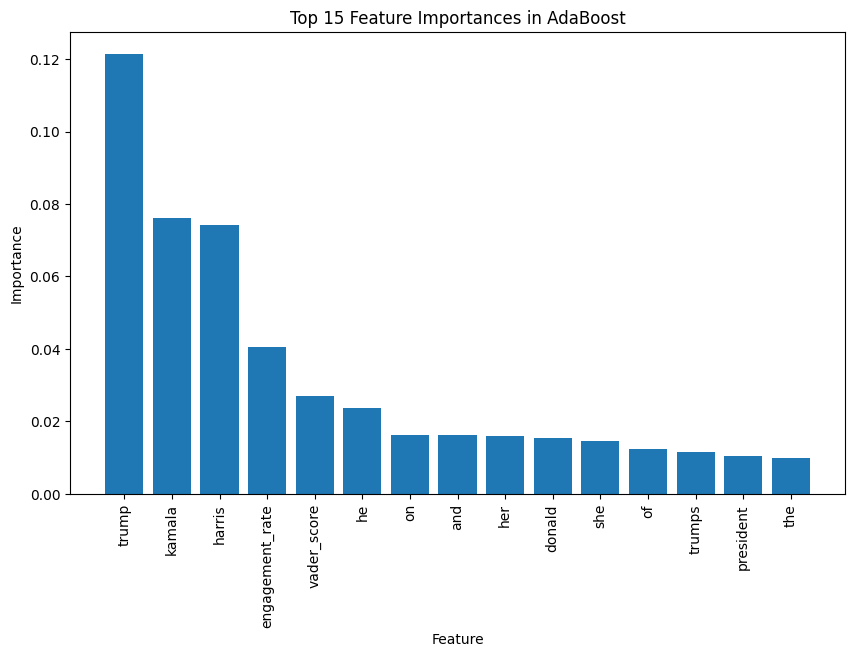

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importance from AdaBoost model
feature_importances = model.feature_importances_
feature_names = X_train.columns  # Get feature names

# Sort features by importance (descending order)
indices = np.argsort(feature_importances)[::-1]

# Select top 15 features
top_n = 15
top_indices = indices[:top_n]
top_features = np.array(feature_names)[top_indices]
top_importances = feature_importances[top_indices]

# Plot the top 15 features
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances in AdaBoost")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_features, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

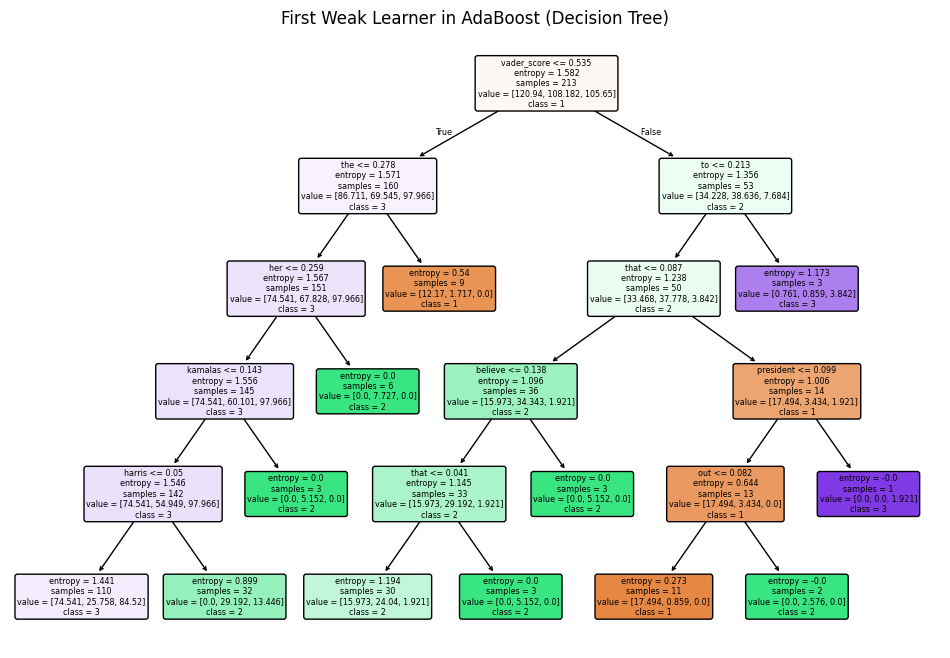

In [60]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get first weak learner (decision tree)
first_tree = model.estimators_[0]

# Dynamically extract class names from Y_train
class_labels = [str(label) for label in np.unique(Y_train)]

# Ensure it's a Decision Tree before plotting
if hasattr(first_tree, "tree_"):
    plt.figure(figsize=(12, 8))
    plot_tree(
        first_tree, 
        feature_names=X_train.columns, 
        class_names=class_labels,  # Use dynamically extracted class names
        filled=True, rounded=True
    )
    plt.title("First Weak Learner in AdaBoost (Decision Tree)")
    plt.show()
else:
    print("First weak learner is not a decision tree. Check AdaBoost configuration.")



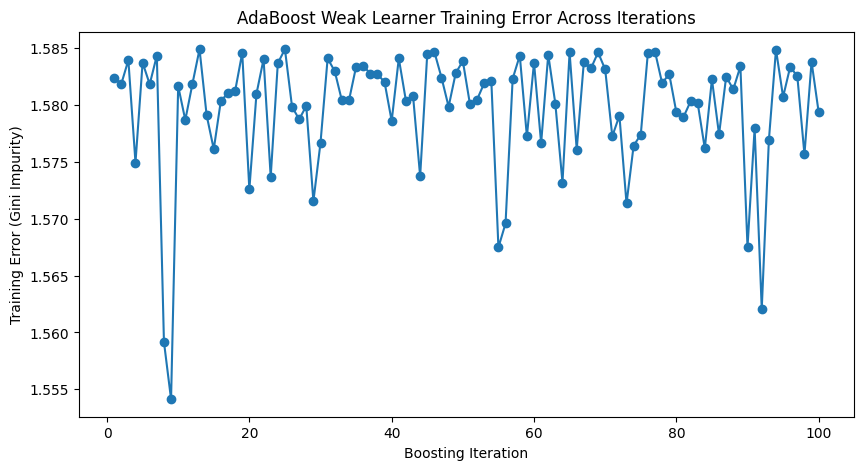

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the training errors from each weak learner
errors = np.array([estimator.tree_.impurity[0] for estimator in model.estimators_])

# Plot training error across boosting iterations
plt.figure(figsize=(10,5))
plt.plot(range(1, len(errors)+1), errors, marker='o', linestyle='-')
plt.xlabel("Boosting Iteration")
plt.ylabel("Training Error (Gini Impurity)")
plt.title("AdaBoost Weak Learner Training Error Across Iterations")
plt.show()



In [62]:
# Compute mean feature values for each candidate
feature_means_by_candidate = X_train.groupby(Y_train).mean()

# Compare Candidate 3 to others
candidate_3_diff = feature_means_by_candidate.loc[3] - feature_means_by_candidate.loc[[1, 2]].mean()

# Show top differences
print(candidate_3_diff.sort_values(ascending=False).head(20))

day              0.135411
August           0.032582
on               0.028068
July             0.025607
November         0.023570
trump            0.023369
as               0.019466
do               0.017691
assassination    0.017547
yall             0.017371
crazy            0.016608
president        0.016254
million          0.015695
with             0.014517
about            0.013683
after            0.013616
believe          0.013503
chris            0.013303
victory          0.013084
should           0.012974
dtype: float64


In [63]:
import pandas as pd

# Compute mean feature values for each candidate
feature_means_by_candidate = X_train.groupby(Y_train).mean()

# Compare Candidate 2 to Candidate 1
candidate_2_vs_1 = feature_means_by_candidate.loc[2] - feature_means_by_candidate.loc[1]
candidate_2_vs_1_sorted = candidate_2_vs_1.sort_values(ascending=False)

# Compare Candidate 1 to Candidate 2
candidate_1_vs_2 = feature_means_by_candidate.loc[1] - feature_means_by_candidate.loc[2]
candidate_1_vs_2_sorted = candidate_1_vs_2.sort_values(ascending=False)

# Convert to DataFrames for better readability
candidate_2_vs_1_df = candidate_2_vs_1_sorted.to_frame()
candidate_2_vs_1_df.columns = ["Difference (Candidate 2 - Candidate 1)"]

candidate_1_vs_2_df = candidate_1_vs_2_sorted.to_frame()
candidate_1_vs_2_df.columns = ["Difference (Candidate 1 - Candidate 2)"]

# Display the top 20 distinctive features for each comparison
print("🔹 Features that appear more in Candidate 2's tweets than Candidate 1's:")
print(candidate_2_vs_1_df.head(20))

print("\n🔹 Features that appear more in Candidate 1's tweets than Candidate 2's:")
print(candidate_1_vs_2_df.head(20))

#overall trend (similar to direction) harris has more indirect related tweets while trump is more direct 
# for exmaple, harris as a lot of identifiers with biden, or walz while trump has win, election, etc

🔹 Features that appear more in Candidate 2's tweets than Candidate 1's:
             Difference (Candidate 2 - Candidate 1)
day                                        1.268253
vader_score                                0.145468
kamala                                     0.090866
harris                                     0.077592
July                                       0.044794
she                                        0.039916
her                                        0.038240
October                                    0.022015
biden                                      0.019635
be                                         0.018073
for                                        0.017947
but                                        0.017060
September                                  0.016829
anyone                                     0.014517
does                                       0.013889
from                                       0.013764
than                                       0

In [64]:
########################################
# STEP 6: Evaluate on test set
########################################
X_train_f = pd.concat([X_train, X_val])
Y_train_f = pd.concat([Y_train, Y_val])
print("Shape:", X_train_f.shape)
# WARNING:
# this code should be run only once;
# after the hyperparameters have been decided based on the validation performance,
# then the False can be changed to True to run this code
if True:
    test_accuracy = model.score(X_test, Y_test)
    print(f"test_accuracy={test_accuracy}")

    y_test_pred = model.predict(X_test)

    # Compute test set metrics
    print("Test Set Metrics:")
    print(classification_report(Y_test, y_test_pred))

Shape: (400, 487)
test_accuracy=0.81
Test Set Metrics:
              precision    recall  f1-score   support

           1       0.78      0.95      0.86        44
           2       0.84      0.97      0.90        39
           3       1.00      0.06      0.11        17

    accuracy                           0.81       100
   macro avg       0.87      0.66      0.62       100
weighted avg       0.84      0.81      0.75       100



In [65]:
y_all_pred = model.predict(x_train)

df_model2 = df_model.reset_index(drop=True)  # Ensure alignment
df_model2['candidate_pred'] = y_all_pred

accuracy = (df_model2['Candidate'] == df_model2['candidate_pred']).mean()
print(f"Overall accuracy on full 500 samples: {accuracy:.4f}")

df_mistakes = df_model2[df_model['Candidate'] != df_model2['candidate_pred']]
print(df_mistakes[['fullText', 'Candidate', 'candidate_pred']].head(10))





Overall accuracy on full 500 samples: 0.8640
                                             fullText  Candidate  \
1   i can’t believe trump is really launching a pr...          3   
4   i think weve all confused jerry brown with wil...          3   
29  how do yall feel about trumps proposal to abol...          3   
32  so republicans are mad bc they (falsely) belie...          3   
35  let me get this straight: democrats lied to th...          3   
44  us political class wants us to believe ✌️unity...          3   
48       do you believe kamala harris is a gun owner?          3   
52   he is from my state and i dont believe that h...          2   
57  i think merchan would have kept the 9/18 sente...          3   
79  i believe one reason is no longer holding rall...          1   

    candidate_pred  
1                1  
4                1  
29               1  
32               2  
35               2  
44               1  
48               2  
52               1  
57               

In [66]:
df_model2.head(5)

,fullText,day,July,August,September,October,November,likes,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment,vader_score,candidate_pred
0,i think what people aren’t taking about enough...,14,0,1,0,0,0,0.000025,0.000010,0.000023,0.000019,0.020858,1,1,indirect,negative,-0.4404,1
1,i can’t believe trump is really launching a pr...,13,0,0,0,1,0,0.000208,0.000052,0.000139,0.000889,0.035637,2,3,neutral,neutral,0.0000,1
2,trump on the radio show sid & friends in the m...,7,0,0,0,1,0,0.000024,0.000062,0.000054,0.000057,0.011930,3,1,indirect,negative,0.9423,1
3,most of these trump supporting men are lonely ...,21,0,0,1,0,0,0.000021,0.000010,0.000003,0.000019,0.117333,4,1,indirect,negative,-0.7003,1
4,i think weve all confused jerry brown with wil...,9,0,1,0,0,0,0.000178,0.000146,0.000071,0.000227,0.053209,5,3,neutral,neutral,0.0516,1


In [67]:
##############################
# add new linguistic features
#############################

# 1. Linguistic & Lexical Features
df_model2['avg_word_length'] = df_model2['fullText'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
df_model2['n_unique_words'] = df_model2['fullText'].apply(lambda x: len(set(x.split())))
df_model2['text_length'] = df_model2['fullText'].apply(len)
df_model2['word_count'] = df_model2['fullText'].apply(lambda x: len(x.split()))
df_model2['n_negations'] = df_model2['fullText'].str.count(r'\b(not|no|never|don\'t|doesn\'t|can\'t|won\'t|isn\'t|ain\'t)\b')

# 2. Tone & Emotion Features
df_model2['textblob_polarity'] = df_model2['fullText'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_model2['n_emojis'] = df_model2['fullText'].str.count(r'[^\w\s,]')

# 3. Political Lexicon Features
support_words = ['vote', 'support', 'endorse', 'leader', 'elect', '💙']
attack_words = ['fraud', 'corrupt', 'criminal', 'lie', 'scandal', 'rigged', 'communist', 'steal']

df_model2['n_support_words'] = df_model2['fullText'].apply(lambda x: sum(word in x.lower() for word in support_words))
df_model2['n_attack_words'] = df_model2['fullText'].apply(lambda x: sum(word in x.lower() for word in attack_words))

# 4. Engagement Tier (optional — if engagement_rate exists)
if 'engagement_rate' in df_model2.columns:
    df_model2['engagement_tier'] = pd.qcut(df_model2['engagement_rate'], q=4, labels=False, duplicates='drop') 

df_model2 = df_model2[df_model2["Candidate"] != 3]
df_model2 = pd.get_dummies(df_model2, columns=['candidate_pred'], prefix='candidate_pred')
df_model2 = df_model2.drop(columns = ['Candidate'])
df_model2['Sentiment'] = df_model2['Sentiment'].str.strip().str.lower()  # Remove spaces & lowercase
candidate_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
df_model2['Sentiment'] = df_model2['Sentiment'].map(candidate_mapping)
df_model2['Sentiment'] = df_model2['Sentiment'].fillna(1).astype(int)
df_model2.head(5)


,fullText,day,July,August,September,October,November,likes,retweets,views,...,word_count,n_negations,textblob_polarity,n_emojis,n_support_words,n_attack_words,engagement_tier,candidate_pred_1,candidate_pred_2,candidate_pred_3
0,i think what people aren’t taking about enough...,14,0,1,0,0,0,0.000025,0.000010,0.000023,...,33,1,-0.216667,2,1,0,0,True,False,False
2,trump on the radio show sid & friends in the m...,7,0,0,0,1,0,0.000024,0.000062,0.000054,...,53,1,0.389286,11,1,0,0,True,False,False
3,most of these trump supporting men are lonely ...,21,0,0,1,0,0,0.000021,0.000010,0.000003,...,31,0,-0.091071,0,1,0,2,True,False,False
6,if you believe kamalas policies will bring dow...,11,0,0,1,0,0,0.000331,0.000489,0.000042,...,20,0,-0.318519,0,0,1,3,False,True,False
8,i know its early and its foolish for me to say...,19,0,0,0,1,0,0.002815,0.001663,0.000522,...,55,0,0.300000,0,0,1,2,False,True,False


In [68]:
########################
# split data
########################

x_train2 = df_model2.drop(columns=['fullText', 'Sentiment', 'direction', 'id'])

y_train2 = df_model2['Sentiment'].reset_index(drop=True)

# Step 7: Verify Final Data
print("Final x_train shape:", x_train2.shape)
print("Final y_train shape:", y_train2.shape)
print(x_train2.head()) 
print(y_train2.head())

Final x_train shape: (414, 25)
Final y_train shape: (414,)
   day  July  August  September  October  November     likes  retweets  \
0   14     0       1          0        0         0  0.000025  0.000010   
2    7     0       0          0        1         0  0.000024  0.000062   
3   21     0       0          1        0         0  0.000021  0.000010   
6   11     0       0          1        0         0  0.000331  0.000489   
8   19     0       0          0        1         0  0.002815  0.001663   

      views  comments  ...  word_count  n_negations  textblob_polarity  \
0  0.000023  0.000019  ...          33            1          -0.216667   
2  0.000054  0.000057  ...          53            1           0.389286   
3  0.000003  0.000019  ...          31            0          -0.091071   
6  0.000042  0.000170  ...          20            0          -0.318519   
8  0.000522  0.002100  ...          55            0           0.300000   

   n_emojis  n_support_words  n_attack_words  engag

In [69]:
########################################
# Create train/test sets
########################################

from sklearn.model_selection import train_test_split

# Step 1: Split into train + test
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(
    x_train2, y_train2, test_size=0.20, random_state=42, stratify=y_train2  # <- fix here
)

# Step 2: Split train into train + validation
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(
    X_train2, Y_train2, test_size=0.25, random_state=42, stratify=Y_train2
)

# Print new distributions
print("New Training Class Distribution:\n", Y_train2.value_counts(normalize=True))
print("\nNew Validation Class Distribution:\n", Y_val2.value_counts(normalize=True))
print("\nNew Test Class Distribution:\n", Y_test2.value_counts(normalize=True))

# Print final shapes
print(f"Training set: X_train={X_train2.shape}, Y_train={Y_train2.shape}")
print(f"Validation set: X_val={X_val2.shape}, Y_val={Y_val2.shape}")
print(f"Test set: X_test={X_test2.shape}, Y_test={Y_test2.shape}")

New Training Class Distribution:
 Sentiment
-1    0.705645
 1    0.294355
Name: proportion, dtype: float64

New Validation Class Distribution:
 Sentiment
-1    0.698795
 1    0.301205
Name: proportion, dtype: float64

New Test Class Distribution:
 Sentiment
-1    0.710843
 1    0.289157
Name: proportion, dtype: float64
Training set: X_train=(248, 25), Y_train=(248,)
Validation set: X_val=(83, 25), Y_val=(83,)
Test set: X_test=(83, 25), Y_test=(83,)


In [70]:
standardize = sklearn.preprocessing.StandardScaler(
    with_mean=True,
    with_std=True,
    )
standardize.fit(x_train2) # all of these feature transformations have; => "learned"
x_train2 = standardize.transform(x_train2)
X_train2 = standardize.transform(X_train2)
X_test2 = standardize.transform(X_test2)
X_val2 = standardize.transform(X_val2)
print(f"x_train.shape={x_train.shape}")

# scale the data to a finite range
scaler = sklearn.preprocessing.MaxAbsScaler()
scaler.fit(x_train2)
x_train2 = scaler.transform(x_train2)
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)
X_val2 = scaler.transform(X_val2)
print(f"x_train.shape={x_train2.shape}")

x_train.shape=(500, 487)
x_train.shape=(414, 25)


In [71]:
########################################
# Train a model
########################################
from sklearn.metrics import classification_report


# MODELS
svm_model = sklearn.svm.SVC(
    C=1,
    kernel='linear',
    degree=3,
    gamma='scale',
    tol=1e-3,
    max_iter=2000,
    cache_size=200,
    random_state=42
)

sentiment_model = sklearn.ensemble.AdaBoostClassifier(
    estimator=sklearn.tree.DecisionTreeClassifier(
        criterion= 'gini',
        max_depth=7,
        max_features = 'sqrt',
        max_leaf_nodes=10,
        min_samples_leaf=2,
        min_samples_split=2,
        class_weight='balanced',  # optional
        random_state=42,
    ),
    n_estimators=35,
    learning_rate=0.5,
    random_state=42
)

model_rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

# ✅ TRAIN all models on X_train2, Y_train2
sentiment_model.fit(X_train2, Y_train2)
svm_model.fit(X_train2, Y_train2)
model_rf.fit(X_train2, Y_train2)

# === DT Evaluation ===
print(f"\n📊 DT")
print(f"Validation Accuracy: {sentiment_model.score(X_val2, Y_val2):.4f}")
print(f"Train Accuracy: {sentiment_model.score(X_train2, Y_train2):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train2, sentiment_model.predict(X_train2)))
print("Validation Set Metrics:")
print(classification_report(Y_val2, sentiment_model.predict(X_val2)))

# === SVM Evaluation ===
print(f"\n📊 SVM")
print(f"Validation Accuracy: {svm_model.score(X_val2, Y_val2):.4f}")
print(f"Train Accuracy: {svm_model.score(X_train2, Y_train2):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train2, svm_model.predict(X_train2)))
print("Validation Set Metrics:")
print(classification_report(Y_val2, svm_model.predict(X_val2)))

# === Random Forest Evaluation ===
print(f"\n📊 Random Forest")
print(f"Validation Accuracy: {model_rf.score(X_val2, Y_val2):.4f}")
print(f"Train Accuracy: {model_rf.score(X_train2, Y_train2):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train2, model_rf.predict(X_train2)))
print("Validation Set Metrics:")
print(classification_report(Y_val2, model_rf.predict(X_val2)))



📊 DT
Validation Accuracy: 0.6145
Train Accuracy: 0.9315
Train Set Metrics:
              precision    recall  f1-score   support

          -1       0.98      0.93      0.95       175
           1       0.84      0.95      0.89        73

    accuracy                           0.93       248
   macro avg       0.91      0.94      0.92       248
weighted avg       0.94      0.93      0.93       248

Validation Set Metrics:
              precision    recall  f1-score   support

          -1       0.73      0.71      0.72        58
           1       0.37      0.40      0.38        25

    accuracy                           0.61        83
   macro avg       0.55      0.55      0.55        83
weighted avg       0.62      0.61      0.62        83


📊 SVM
Validation Accuracy: 0.7349
Train Accuracy: 0.7419
Train Set Metrics:
              precision    recall  f1-score   support

          -1       0.73      0.99      0.84       175
           1       0.91      0.14      0.24        73

    a

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from itertools import product

# Define your parameter grid
param_grid = {
    'n_estimators': [35, 55, 75, 100],            # AdaBoost
    'max_depth': [5, 7, 12, 15],                  # DecisionTree
    'min_samples_split': [2, 5],                 # DecisionTree
    'min_samples_leaf': [1, 2],                  # DecisionTree
    'max_features': ['sqrt', 'log2'],            # DecisionTree
    'criterion': ['gini', 'entropy']             # DecisionTree
}

# Create all combinations
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

best_model = None
best_score = 0
best_params = {}

for params in param_combinations:
    model = RandomForestClassifier(
        **params,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train2, Y_train2)
    score = model.score(X_val2, Y_val2)  # <-- your actual validation set
    
    if score > best_score:
        best_score = score
        best_model = model
        best_params = params

print("✅ Best Params (based on validation):", best_params)
print("⭐ Best Validation Accuracy:", round(best_score, 4))



✅ Best Params (based on validation): {'n_estimators': 55, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'entropy'}
⭐ Best Validation Accuracy: 0.747


In [73]:
from sklearn.svm import SVC

# Grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'poly', 'linear']  # you could also test 'linear'
}

svm_keys, svm_values = zip(*svm_param_grid.items())
svm_combos = [dict(zip(svm_keys, v)) for v in product(*svm_values)]

best_svm_model = None
best_svm_score = 0
best_svm_params = {}

for params in svm_combos:
    svm_model = SVC(
        **params,
        tol=1e-3,
        max_iter=2000,
        cache_size=200,
        random_state=42    )
    svm_model.fit(X_train2, Y_train2)
    val_score = svm_model.score(X_val2, Y_val2)

    if val_score > best_svm_score:
        best_svm_score = val_score
        best_svm_model = svm_model
        best_svm_params = params

print("\n🔮 Best SVM Params:", best_svm_params)
print("⭐ Best SVM Validation Accuracy:", round(best_svm_score, 4))



🔮 Best SVM Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
⭐ Best SVM Validation Accuracy: 0.7349


C:\Users\agrey25\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\agrey25\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\agrey25\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [74]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from itertools import product

# Define hyperparameter grid
param_grid = {
    'n_estimators': [35, 55, 100],
    'learning_rate' : [0.1, 0.5, 1],          # AdaBoost       
    'max_depth': [5, 7, 15],                  # DecisionTree
    'min_samples_split': [2, 5],                 # DecisionTree
    'min_samples_leaf': [1, 2],   
    'max_leaf_nodes': [5, 10],
    'max_features': ['sqrt', 'log2'],            # DecisionTree
    'criterion': ['gini', 'entropy']             # DecisionTree
}

# Generate all combinations
keys = list(param_grid.keys())
values = [param_grid[k] for k in keys]
combinations = list(product(*values))

# Track best model
best_boost_model = None
best_boost_score = 0
best_boost_params = {}

# Manual search loop
for combo in combinations:
    params = dict(zip(keys, combo))
    
    # Define base tree with relevant params
    base_tree = sklearn.tree.DecisionTreeClassifier(
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_leaf_nodes=params['max_leaf_nodes'],
        class_weight='balanced',
        random_state=42
    )
    
    # AdaBoost wrapper
    model = sklearn.ensemble.AdaBoostClassifier(
        estimator=base_tree,
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        random_state=42
    )
    
    # Train on original (non-SMOTE) data
    model.fit(X_train2, Y_train2)
    val_score = model.score(X_val2, Y_val2)

    if val_score > best_boost_score:
        best_boost_score = val_score
        best_boost_model = model
        best_boost_params = params

# Results
print("\n⚡ Best AdaBoost+DT Params (Validation-Based):", best_boost_params)
print("⭐ Best Validation Accuracy:", round(best_boost_score, 4))

# 🧪 Evaluate best model on validation + training sets
from sklearn.metrics import classification_report

print("\n📊 Evaluating Best Model...")

# Validation accuracy & metrics
print(f"Validation Accuracy: {best_boost_model.score(X_val2, Y_val2):.4f}")
print("Validation Set Metrics:")
print(classification_report(Y_val2, best_boost_model.predict(X_val2)))

# Train accuracy & metrics
print(f"\nTrain Accuracy: {best_boost_model.score(X_train2, Y_train2):.4f}")
print("Train Set Metrics:")
print(classification_report(Y_train2, best_boost_model.predict(X_train2)))




⚡ Best AdaBoost+DT Params (Validation-Based): {'n_estimators': 35, 'learning_rate': 0.5, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': 10, 'max_features': 'sqrt', 'criterion': 'gini'}
⭐ Best Validation Accuracy: 0.7229

📊 Evaluating Best Model...
Validation Accuracy: 0.7229
Validation Set Metrics:
              precision    recall  f1-score   support

          -1       0.78      0.84      0.81        58
           1       0.55      0.44      0.49        25

    accuracy                           0.72        83
   macro avg       0.66      0.64      0.65        83
weighted avg       0.71      0.72      0.71        83


Train Accuracy: 1.0000
Train Set Metrics:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       175
           1       1.00      1.00      1.00        73

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00

In [75]:
if True:
# DT
    best_boost_model.fit(X_train2, Y_train2)
    test_accuracy = best_boost_model.score(X_test2, Y_test2)
    print(f"DT test_accuracy={test_accuracy}")
    
    model_rf.fit(X_train2, Y_train2)
    test_accuracy = model_rf.score(X_test2, Y_test2)
    print(f"RF test_accuracy={test_accuracy}")
    
    svm_model.fit(X_train2, Y_train2)
    test_accuracy = svm_model.score(X_test2, Y_test2)
    print(f"SVM test_accuracy={test_accuracy}")

    sentiment_model.fit(X_train2, Y_train2)
    test_accuracy = sentiment_model.score(X_test2, Y_test2)
    print(f"DT2 test_accuracy={test_accuracy}")

DT test_accuracy=0.7108433734939759
RF test_accuracy=0.6867469879518072
SVM test_accuracy=0.6506024096385542
DT2 test_accuracy=0.6024096385542169


C:\Users\agrey25\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
